# Tutorial on Creating Rugged Landscapes

In this tutorial, you will be introduced to a simple model to create NK landscapes following Levinthal (1997). The tutorial does not include search in rugged landscapes, just the creation of the landscapes. You can find a code with the search process in the levinthal.ipynb file in this repository.  

**Reference:** Levinthal, D. A. (1997). Adaptation on rugged landscapes. Management science, 43(7), 934-950.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# NK landscape
In Levinthal (1997) the agent is quite simple. The environment does have some intricancies. 

## 1. Create dependencies
The k interdependencies in Levinthal's are created at random. Basically, one needs a matrix where the diagonal has a 1 and the off-diagonal has k ones and n-k zeroes. A one represents an interdependency and a zero the lack of it.  
This function includes two variables N and K and outputs a NxN interdependency matrix. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_dependencies(n, k, land_style):
    dep_mat = np.zeros((n,n)).astype(int)
    inter_row = [1]*k+[0]*(n-k-1) # number of off-diagonals 1s and 0s
    if land_style == "Rand_mat": 
        inter = np.random.choice(inter_row*n, replace = False, size = n*(n-1))
    for i in range(n):
        if land_style == "Rand_row": inter = np.random.choice(inter_row, replace = False, size = (n-1))
        elif land_style == "Levinthal": inter = inter_row # The original order is the one from Levinthal (1997)
        range_row = list(range(n)[i:])+list(range(n)[:i])
        for j in range_row:
            if i != j: 
                dep_mat[i][j] = inter[0]
                inter = inter[1:]
            else: dep_mat[i][i] = 1
    return(dep_mat)

### 1.1 Example: How to create a interdependency matrix
Below you see how an interdependency matrix is built. If you run the code again, the matrix will change. 

In [2]:
n = 3
k = 1
land_style = "Rand_mat"
dep_mat = create_dependencies(n, k, land_style)

dep_mat

array([[1, 0, 1],
       [1, 1, 0],
       [0, 1, 1]])

### 1.2. Miscellaneous function: Int2Pol
This is a miscellaneous function. It is presented here to avoid confusion. It will be use by the next functions.  
This function takes an integer value and outputs a string of 0s and 1s of length N. This is important as the binary function of Python truncates any zero to the left of the most significant 1. 

In [3]:
def int2pol(pol_int, n):
    pol = bin(pol_int)
    pol = pol[2:] # removes the '0b'
    if len(pol) < n: pol = '0'*(n-len(pol)) + pol
    return(pol)

int2pol(pol_int = 5, n = 4)

'0101'

## 2. Fitness contributions
The second step is building the fitness contributions for each item in the interdependency matrix. Before showing the code, it is important to present the logic of it, here we do so by an example.

### 2.1 Example
Let's imagine that our interdependency matrix is: 
   
|1 0 0|  
|0 1 1|  
|1 1 1|  

What this means is that the fitness contributions of the first value of a policy P = [a,b,c] will depend ONLY on the value of the first policy value, namely whether a is 1 or 0. Formally the fitness contribution will have twwo values:  
* f1[0] = z0  
* F1[1] = z1  
Where z0 and z1 are numbers drawn from a uniform distribution. 
  
The second row is more complicated as there is one interdependency. Here we will have that the second and third policy values are needed to calculate the fitness contribution. For this we need a function with four values as there are four possible combinations of a and b. The functions have the form f2[b,c].  
* f2[00] = y0
* f2[01] = y1
* f2[10] = y2
* f2[11] = y3

The final row has 3 interdependencies. Now the fitness contributions depends on the values of a, b, and c. The fitness contribution has the for f3[a,b,c]. To depict it, we draw a truth table.   
  
a  b  c  |  f3  
0  0  0  |  x0  
0  0  1  |  x1  
0  1  0  |  x2  
0  1  1  |  x3  
1  0  0  |  x4  
1  0  1  |  x5  
1  1  0  |  x6  
1  1  1  |  x7  

To create the fitness contributions we need a function that takes one interdependence matrix and outputs the fitness contributions functions for each position. That is, a function that outputs the two f1, four f2, and eight f3.  
The function later on should have a structure such that if one tells it that a = 0 and b = 1 it can give f2[b,a] = y2. For this the ideal structure is a list of dictionaries. Each fitness contribution function is a dictionary that one gives the values and it outputs the  and the dictionaries are joined together in a list. Below you find a function that does just that.

### 2.2 Fitness contribution generator
The function first creates an empty list. This list will be filled with the dictionaries of fitness contribution functions.   
The next step is entering a for-loop over the N rows of the interdependency matrix. For each iteration in the for-loop, we do a list comprehension where the binary value of the counter is stored as the key of a dictionary with the value drawn from a uniform distribution. The second for-loop will go over 2^q iterations, where q is the number of 1's in the row. As in the example=, q is on average k+1 but not always. At the end the function output a list of with the dictionaries as its entry.  
You see the code below and the outputs is the list of dictionaries of the dependency matrix created in the prior section. 

In [4]:
def fitness_contribution(dep_mat):
    fit_con = []
    for i in range(len(dep_mat)): 
        epi_row = {int2pol(j,sum(dep_mat[i])): np.random.random() for j in range(2**sum(dep_mat[i]))}
        fit_con.append(epi_row)
    return(fit_con)

fit_con = fitness_contribution(dep_mat)
fit_con

[{'00': 0.7127311116949466,
  '01': 0.9266009742141128,
  '10': 0.7695282204770948,
  '11': 0.8747144359604497},
 {'00': 0.16038573516750165,
  '01': 0.7739492531050982,
  '10': 0.8330287137103191,
  '11': 0.15385850909794307},
 {'00': 0.256228595916425,
  '01': 0.0449117960882045,
  '10': 0.04360355592287435,
  '11': 0.5598928908931241}]

## 3. Calculate policy payoffs
The next step is to calculate the payoff of a policy based upon the fitness contribution functions. To do this we require two things. First to calculate the payoff contribution of every value in a policy and then sum all of them together. We start with the first task. 
  
### 3.1 Transform Row
Let's continue with the example. But now we have the policy P = '101'. This policy has three elements and is stored as a string of 0s and 1s.  
In the case of the first value we know we should get z0 as fitness contribution. In the second row, y2 and so on. To do this we need to create a function that takes the values of the policy and matches them to the values other values that are interdependent with it.  
The function below is given two inputs, a policy and a row of a dependency matrix.  It creates an empty list and starts to populate it. It does this by starting a for-loop for every element of the policy. If the item of that index is 1 in the interdependency row then it appends the value of policy to the list. If not, it continues to the next policy value. In this way, only the interdependent items are stored. With this, the programs has a list with items that are relevant to calculate the fitness contribution for this policy.  
For example, in the case from before we would have as an output of the for-loop '1' in the first row, '01' in the second row and '101' for the last row. This output is called interact_row.  
These values however are not understandable by the dictionaries of the fitness contribution. The last rows of the function translate the list into a binary value. So that later the dictonary can be queried.  
The process starts by starting trans_pol = 0. This value will store the key value for the dictionary. Then a for-loop starts. The for-loop has the range reversed so that the we keep the items to the left of the list being more significant. This is important because in the the next step we multiply the value of interact_row[i] with the 2^index value. By reversing the order we have that the item most to left in the list will be multiplied by 2^3 if we follow the example from before, the item next to it by 2^2 and so on. The product of the multiplications is added on every loop to the trans_pol value. At the end we have a decimal value. We transform the decimal value and the output is a key we can use in the dictionaries from the fitness contribution. For example for the first row from before we get '1', for the second '01', and for the last row, '101'.  
Below you see an example of this function for the same policy we have used in this example but for the randomly generate dependency matrix from before.  

In [5]:
def transform_row(policy, dep_row):
    interact_row = [policy[i] for i in range(len(policy)) if dep_row[i] == 1]
    trans_pol = ''
    for pol_i in interact_row: trans_pol += pol_i
    return(trans_pol)

transform_row('101', dep_mat[1])

'10'

### 3.2 Transform Matrix
The transform_row function is called by a transform_matrix function whose job is to take a policy and output a set of keys for the the list of fitness contributions. To do this basically what it does is to to call the transform_row N times can fill out a list with the output of each of the calls of the function. In the example from above we would have: ['0b0',  '0b11', '0b101'] as an output. Below you see an example of the function working.  

In [6]:
def transform_matrix(policy, dep_mat):
    int_mat = [transform_row(policy, dep_mat[i]) for i in range(len(dep_mat))]
    return(int_mat)

transform_matrix('101',dep_mat)

['11', '10', '01']

### 3.3 Payoff
The payoff function has three inputs, the policy for which to calculate a payoff, the interdependency matrix, and the list of fitness contributions.  The first action it does it to transform the policy into keys to the fitness cotnribution dictionaries. After this is done it sums the entries of all the fitness contributions of the key values and divides the sum by the length of the policy. The last part is done to get a value between 0 and 1. Below we see and example of the code working. 

In [7]:
def payoff(policy,dep_mat,fit_con):
    keys = transform_matrix(policy, dep_mat)
    pay = np.sum([fit_con[i][keys[i]]/len(policy) for i in range(len(policy))])
    return(pay)

payoff('101',dep_mat,fit_con)

0.5842183152529912

## 4. Make full-landscape
Now that we can calculate the payoff for one policy we can make the full-landscape. However, to calculate the landscape we need to make a function that takes integers and makes policies.  

### 4.1 Calculate Landscape
Having the translating function, the function that calculates the landscape is just a for-loop that fills up a dataframe. The dataframe consists of three entries per policy: The policy in list-value, the policy in integer-value, and the payoff. The integer value of the policy is used for accessing the dataframe, the list-value for searching the landscape.   
Below you will see an example.  

In [8]:
def calc_landscape(dep_mat, fit_con):
    land = {}
    n = len(fit_con)
    for i in range(2**n):
        pol = int2pol(i,n)
        land[pol] = payoff(pol, dep_mat, fit_con)
    return(land)

lands = calc_landscape(dep_mat, fit_con)
lands

{'000': 0.37644848092629113,
 '001': 0.37729950182327293,
 '010': 0.5100946402409731,
 '011': 0.7534810394041117,
 '100': 0.6195951767012796,
 '101': 0.5842183152529912,
 '110': 0.3223300951659708,
 '111': 0.529488611983839}

### 4.3 Descriptives of the environment
We can characterize the environment. Find the maximum, minimum, number of peaks.  
For this we need a function that finds the peaks, which has to find whether a policy gives the highest performance for every neighbor. 
#### 4.3.1 FInd neighbors
For every policy there are N neighboring positions. These are policies that differ by one change from the current policy. The function shown here takes the starting policy and generates at random the N neighbors. It outputs the integer value of each of these N neighbors. The neighbors are given at random becuase this is useful for the search algorithm. It is not necessary here but does not affect the code. 
Below you see an example. 

In [9]:
def find_neighbors(policy):
    policy = (policy) #policy changed 
    neighbors = []
    random_order = np.random.choice(range(len(policy)), replace = False, size = len(policy))
    for i in random_order:
        neighbor = list(policy)
        if policy[i] == '1': neighbor[i] = '0'
        else: neighbor[i] = '1'
        neighbors.append(''.join(neighbor))
    return(neighbors)

find_neighbors('101')

['001', '111', '100']

#### 4.3.1 Summary
This functions gives a summary of the landscape. The maximum, minimum, and number of peaks. It is most useful for collecting statistics of different landscape configurations (i.e., different n and ks).


In [10]:
def summary(lands):
    max_global = max(lands.values())
    min_global = min(lands.values())
    num_peaks = 0
    for current_row in lands.keys():
        randomized_neighbors = find_neighbors(current_row)
        counter = 0
        for neighbor in randomized_neighbors:
            if lands[current_row] < lands[neighbor]: counter += 1
        if counter == 0: num_peaks += 1
    return([max_global, min_global, num_peaks])

summary(lands)

[0.7534810394041117, 0.3223300951659708, 2]

# Create landscape from scratch  
  
Below you can find the short way of creating the landscape from scratch

In [11]:
n = 6
k = 2
land_style = "Rand_row" # "Levinthal", "Rand_mat", "Rand_row"
dep_mat = create_dependencies(n, k, land_style)
fit_con = fitness_contribution(dep_mat)
Environment = calc_landscape(dep_mat, fit_con)    

summary(Environment)

[0.8093947139676546, 0.25880530257391926, 4]

In [12]:
Environment

{'000000': 0.3214651315528555,
 '000001': 0.37180546899935274,
 '000010': 0.28710810377262247,
 '000011': 0.4738716705312409,
 '000100': 0.45873093416935584,
 '000101': 0.5090712716158531,
 '000110': 0.42437390638912287,
 '000111': 0.6111374731477413,
 '001000': 0.592225074375926,
 '001001': 0.6459930811429667,
 '001010': 0.38228903278649223,
 '001011': 0.5724802688656541,
 '001100': 0.46874134416335306,
 '001101': 0.5225093509303937,
 '001110': 0.25880530257391926,
 '001111': 0.4489965386530812,
 '010000': 0.2932546297002665,
 '010001': 0.30851557155699627,
 '010010': 0.5160727225744646,
 '010011': 0.597252579428877,
 '010100': 0.43052043231676684,
 '010101': 0.4457813741734967,
 '010110': 0.6533385251909649,
 '010111': 0.7345183820453773,
 '011000': 0.48573923617221904,
 '011001': 0.5044278473494923,
 '011010': 0.5022668840922553,
 '011011': 0.5868744102672112,
 '011100': 0.36225550595964606,
 '011101': 0.3809441171369194,
 '011110': 0.3787831538796823,
 '011111': 0.46339068005463824

# Characterize landscapes  
  
Below we characterize a thousand landscapes by describing their maxima, minima, and number of peaks 

In [13]:
import time
start_time = time.time()
all_max = []
all_min = []
all_num_peaks = []
num_reps = 1000
for i in range(num_reps): 
    dep_mat = create_dependencies(n, k, land_style)
    fit_con = fitness_contribution(dep_mat)
    Environment = calc_landscape(dep_mat, fit_con)   
    max_val, min_val, peaks = summary(Environment)
    all_max.append(max_val)
    all_min.append(min_val)
    all_num_peaks.append(peaks)
print("Computation time: "+ str(round(time.time()-start_time, 2)) + " s")

Computation time: 7.63 s


(array([ 12.,  23., 101., 188., 230., 231., 148.,  56.,  10.,   1.]),
 array([0.06853532, 0.1091755 , 0.14981568, 0.19045586, 0.23109605,
        0.27173623, 0.31237641, 0.35301659, 0.39365677, 0.43429696,
        0.47493714]),
 <a list of 10 Patch objects>)

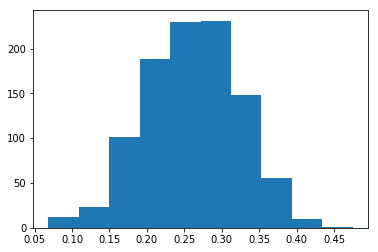

In [14]:
plt.hist(all_min)

(array([  1.,   5.,  32., 110., 207., 303., 207.,  95.,  33.,   7.]),
 array([0.50852598, 0.55118162, 0.59383726, 0.6364929 , 0.67914854,
        0.72180418, 0.76445982, 0.80711546, 0.8497711 , 0.89242674,
        0.93508239]),
 <a list of 10 Patch objects>)

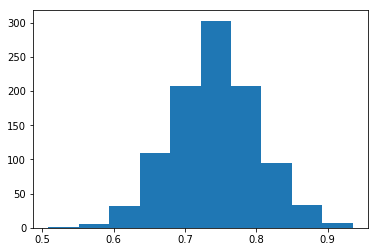

In [15]:
plt.hist(all_max)

(array([ 22., 187., 321., 286.,   0., 134.,  39.,   9.,   1.,   1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

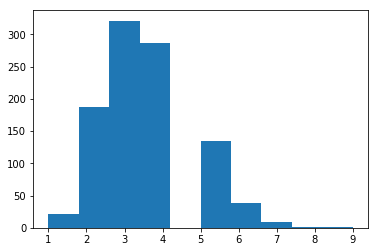

In [16]:
plt.hist(all_num_peaks)

# Search
With the environment finished it is time to search in this rugged landscape. 

  
**Note:** The code below builds the table of content.

In [18]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>